# Facial Expression Recognition (FER)
**OVERVIEW:**
  The model in this notebook are designed using Convolutional Neural Network (CNN) which consists of several convolutional, pooling and classifier layer. ReLU() activation function is used in between layers and a softmax() is used to convert the logits into probabilities. PyTorch framework is used in order to enhance the efficiency and simplicity of execution.



  A light version of AffectNet dataset is used to train the model, which is an open dataset available in kaggle. (The original AffectNet dataset consists of 0.4 million images, which is a huge dataset beyond the scope of the study.) The dataset consists of around 29000 RGB images reduced down to 96 by 96 pixels.

  

  Dataset link: https://www.kaggle.com/datasets/noamsegal/affectnet-training-data

# 1. Setup device agnostic code and import necessary libraries

In [46]:
# Libraries
import torch
import os
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, Subset
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm

# Check the device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Check the device that the code is running on
print(device)

cuda


# 2. Mount the google drive and explore how is the data distributed

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The images are distributed into 8 different folders (the folders name are misleading as they seems to represent eight major expressions). However, the folder name are not the actual label for each images. The labels are found on a different csv file inside the dataset main folder named 'labels.csv'. The file consists of 4 columns. Nevertheless, we are only intrested in two of them:

1. 'pth'-
This column gives the folder name and image name in this format -> 'folder_name/image_name'

2. 'label'-
This column gives the acual label of the image.

Looking the following code and it's return, it is more clear.

In [48]:
import pandas as pd

# Import the 'labels' file and check what is inside....
labels = pd.read_csv('/content/drive/MyDrive/DL AffectNet/labels.csv')
labels.head()

,Unnamed: 0,pth,label,relFCs
0,0,anger/image0000006.jpg,surprise,0.873142
1,1,anger/image0000060.jpg,anger,0.852311
2,2,anger/image0000061.jpg,anger,0.800957
3,3,anger/image0000066.jpg,disgust,0.843079
4,4,anger/image0000106.jpg,anger,0.849108


In [49]:
print(len(labels))

# We are excluding contempt expression
labels = labels[labels['label'] != 'contempt']
print(len(labels))

28175
24931


In [50]:
lab = list(set(labels["label"]))
print(lab)
def label_count(label):
  for i in lab:
    print(f"The number of {i} images is {len(label[label['label'] == i])}")
label_count(labels)

['anger', 'sad', 'surprise', 'disgust', 'happy', 'neutral', 'fear']
The number of anger images is 3608
The number of sad images is 2995
The number of surprise images is 4616
The number of disgust images is 3472
The number of happy images is 4336
The number of neutral images is 2861
The number of fear images is 3043


In [51]:
# Select the number of sample per class
N = 2500

# Group by the 'label' column and sample N rows from each group
balanced_labels = labels.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), N)))

# Shuffle the balanced dataset
balanced_labels = balanced_labels.sample(frac=1).reset_index(drop=True)

labels = balanced_labels

In [52]:
len(balanced_labels)

17500

In [53]:
label_count(balanced_labels)

The number of anger images is 2500
The number of sad images is 2500
The number of surprise images is 2500
The number of disgust images is 2500
The number of happy images is 2500
The number of neutral images is 2500
The number of fear images is 2500


# 3 Import, Visualize and Preprocess the data

## 3.1. Import and Visualize

In [54]:
# Import necessary libraries
import os
from tqdm.auto import tqdm
from PIL import Image
import torch
from torchvision import transforms

In [55]:
# Set the initial data and label list
data=[]
data_labels=[]

print(f'Total images is {N*7}')

# Looping through each row in the 'labels' file and utilizing the 'pth' column to define each individual image directory
for index, row in tqdm(labels.iterrows()):

  # Splitting the folder name and image name
  folder_name,image_name = row['pth'].split('/')

  # Joining the main dataset folder path in google drive, the folder name and each image name
  image_path = os.path.join('/content/drive/MyDrive/DL AffectNet', folder_name,image_name)

  # Using the joined image path and opening the image
  image=Image.open(image_path)

  # Transforming the image into tensors
  # image=transform(image)

  # Adding the transformed tensor image in the data
  data.append(image)

Total images is 17500


0it [00:00, ?it/s]

In [352]:
data_labels = labels["label"]
len(data_labels)

17500

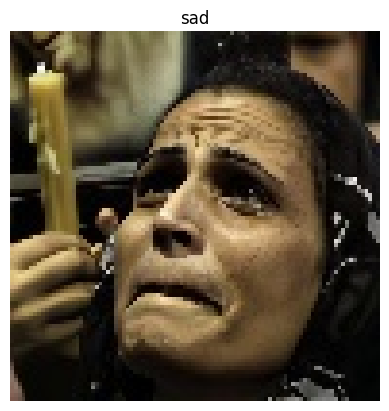

In [415]:
# Visualize
import matplotlib.pyplot as plt
plt.imshow(data[0])
plt.axis(False)
plt.title(data_labels[0])
plt.show()

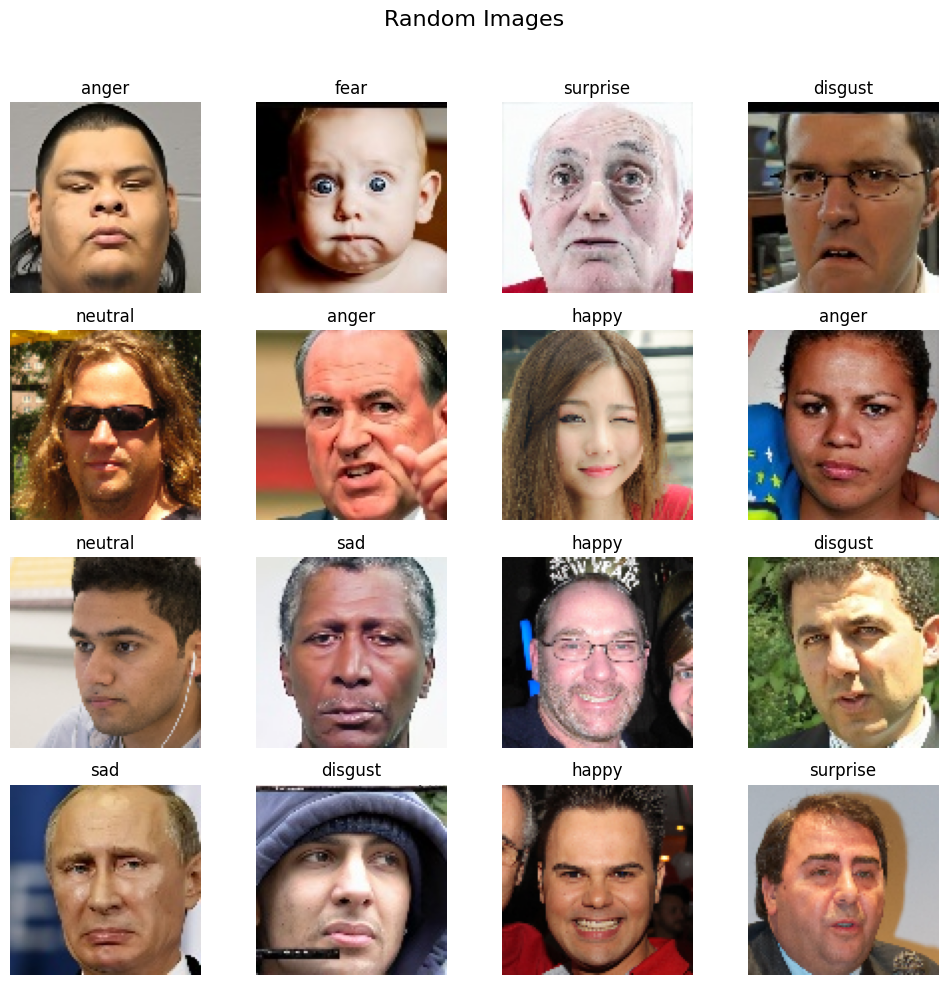

In [416]:
# Plot 16 more images
num_images = 16

# Calculate grid size
grid_size = int(np.ceil(np.sqrt(num_images)))

# Randomly select indices
indices = np.random.choice(len(data), num_images, replace=False)

# Create subplots
fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))
fig.suptitle('Random Images', fontsize=16)

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each image in the subplot
for ax, idx in zip(axes, indices):
    ax.imshow(data[idx], cmap='gray')
    ax.axis('off')
    ax.set_title(data_labels[idx])
for ax in axes[num_images:]:
    ax.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 3.2. Preprocessing

### 3.2.1. Face Detection

In [353]:
# Cropping out the face using opencv model (Face detcetion)
import cv2

# Load the pre-trained Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
from google.colab.patches import cv2_imshow as image_show
import numpy as np

In [354]:
def image_crop(image_list, labels_list):
  cropped_images=[]
  valid_labels = []
  for i, image in enumerate(tqdm(image_list, desc = "Detecting faces from images and cropping")):
    image = np.array(image)
    gray_image = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2GRAY)
    gray_image = gray_image.astype(np.uint8)

    # Perform face detection

    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Check if at least one face is detected
    if len(faces) > 0:
    # Crop the face from the image (taking the first detected face)
      x, y, w, h = faces[0]
      cropped_face = image[y:y+h, x:x+w]
      cropped_images.append(cropped_face)
      valid_labels.append(data_labels[i])
  return cropped_images, valid_labels

### 3.2.2. Histogram Equilization using CLAHE and normalize the image

In [355]:
import cv2
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

In [356]:
def clahe_func_normalization(image_list, clip_limit=2.0, grid_size=4):

  equalized_normalized_image = []

  for image in tqdm(image_list, desc="Performing Histogram Equilization and Normalization"):

    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split the LAB image into its channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size))
    cl_l_channel = clahe.apply(l_channel)

    # Merge the CLAHE enhanced L channel back with A and B channels
    merged_lab_image = cv2.merge((cl_l_channel, a_channel, b_channel))

    # Convert the LAB image back to RGB color space
    clahe_image = cv2.cvtColor(merged_lab_image, cv2.COLOR_LAB2RGB)

    # Normalize the final image to the 0-1 range
    final_normalized_image = clahe_image / 255.0

    equalized_normalized_image.append(final_normalized_image)

  return equalized_normalized_image

### 3.2.3. Resizing and Transforming to tensors

In [357]:
# resizing the image
def resize_image(image_list, size = 64):
  resized_images = []
  for image in image_list:
    resized_image = cv2.resize(image, (size, size))
    resized_images.append(resized_image)
  return resized_images

In [358]:
# Defining tensor transformation
def to_tensor(image_list, labels_list):
  tensor_images = []
  tensor_labels = []
  for image in tqdm(image_list, desc="Converting images to tensors"):
    tensor_images.append(torch.tensor(image))
  for label in tqdm(labels_list, desc="Converting labels to tensors"):
    tensor_labels.append(torch.tensor(label))
  print(len(tensor_images), len(tensor_labels))
  return tensor_images, tensor_labels

### 3.2.4. Preprocessing Pipeline

In [359]:
def preprocessing_pipeline(image_list, label_list):
  image, label = image_crop(image_list, label_list)
  image = clahe_func_normalization(image)
  image = resize_image(image)
  label_set = list(set(label))
  ltoi = {label_set[i]:i for i in range(len(label_set))}
  labels_index = [ltoi[label] for label in label]
  image, label_index = to_tensor(image, labels_index)
  return image, label_index, label, label_set

In [360]:
processed_data, processed_labels, valid_labels, label_set = preprocessing_pipeline(data, data_labels)

Detecting faces from images and cropping:   0%|          | 0/17500 [00:00<?, ?it/s]

Performing Histogram Equilization and Normalization:   0%|          | 0/16127 [00:00<?, ?it/s]

Converting images to tensors:   0%|          | 0/16127 [00:00<?, ?it/s]

Converting labels to tensors:   0%|          | 0/16127 [00:00<?, ?it/s]

16127 16127


In [361]:
# Checking the labels counts after preprocessing
label_counts = {}
lab = list(set(valid_labels))
for label in valid_labels:
  if label not in label_counts:
        label_counts[label] = 1
  else:
        label_counts[label] += 1
# Print the counts
for label, count in label_counts.items():
    print(f"{label} = {count}")

sad = 2238
fear = 2270
anger = 2342
surprise = 2256
neutral = 2301
disgust = 2336
happy = 2384


### 3.2.5. Labels Consistency

In [362]:
print(label_set)
ltoi = {label_set[i]:i for i in range(len(label_set))}
itol = {i:label_set[i] for i in range(len(label_set))}
print(ltoi)
print(itol)

['anger', 'sad', 'surprise', 'disgust', 'happy', 'neutral', 'fear']
{'anger': 0, 'sad': 1, 'surprise': 2, 'disgust': 3, 'happy': 4, 'neutral': 5, 'fear': 6}
{0: 'anger', 1: 'sad', 2: 'surprise', 3: 'disgust', 4: 'happy', 5: 'neutral', 6: 'fear'}


# 4. Split the data in train and test

In [411]:
# Importing train_test_split from scikit-learn library
from sklearn.model_selection import train_test_split

# Splittin 80% of the data into training set and remaining 20% to testing set
X_train, X_test, y_train, y_test = train_test_split(processed_data,
                                                    processed_labels,
                                                    test_size=0.2,
                                                    random_state=42)


In [364]:
# Checking out the length of train and test sets
print(f'The number of training data is {len(X_train)} and training labels is {len(y_train)}')
print(f'The number of testing data is {len(X_test)} and testing labels is {len(y_test)}')

The number of training data is 12901 and training labels is 12901
The number of testing data is 3226 and testing labels is 3226


# 5. Building a Convolutional Neural Network (CNN) model: 'TinyVGG'

The TinyVGG refers to as the smaller version of VGG (Visual Geometry Group) neural network architecture.

The model architecture is explained below:

1. **Convolutional layers:**
* First, the RGB images with 3 channels is passed through a convolutional layer with 3 input  channels.
* After that, in order to add non-linearity as spice, a ReLU() activation function is applied.
* Then, a max-pooling layer is applied in the feature map.
* Following this, another Conv2d (convolutional) layer is added.
* Again, relu activation function is applied.
* A max pool layer as before was applied again.

2. **Fully Connected Layers (classifiers):**
* the feature map is flatten to pass thorugh the classifier.
* Then the flattened feature map is passed through fully connected layer (nn.Linear).
* ReLU() is used here again for non-linearity.
* Droupout layer is introduced (nn.Droupout) to regularize the network to prevent overfitting.
* Another Linear layer maps to 7 classes.

3. **Output:**
* The output from this model gives the logits for each class. Then these logits are passed through softmax activation function to get the proobabilities of each classes during the training, evaluation and implementation of the model.

In [365]:
# Importing torch and nn
import torch
import torch.nn as nn

# Define the model
class TinyVGG(nn.Module):
    def __init__(self, conv1_channels=32, conv2_channels=64, fc1_units=128, dropout_rate=0.5, num_classes=7):
        super(TinyVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, conv1_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(conv1_channels, conv2_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(conv2_channels * 16 * 16, fc1_units),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(fc1_units, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

# 6. Define a custom classifier for RandomizedSearchCV and search for optimum hyperparameters settings


In [366]:
# Define the PyTorch classifier wrapper for RandomizedSearchCV
import torch.optim as optim
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from sklearn.base import BaseEstimator, ClassifierMixin
from torch.utils.data import DataLoader, Subset

class PyTorchClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, conv1_channels=32, conv2_channels=64, fc1_units=128, dropout_rate=0.5, lr=0.001, batch_size=32, epochs=10):
        self.conv1_channels = conv1_channels
        self.conv2_channels = conv2_channels
        self.fc1_units = fc1_units
        self.dropout_rate = dropout_rate
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = TinyVGG(conv1_channels, conv2_channels, fc1_units, dropout_rate).to(self.device)
        self.criterion = nn.CrossEntropyLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=lr)

    def fit(self, X, y):
        self.model.train()
        X = [tensor.to(torch.float32) for tensor in X]
        train_loader = DataLoader(dataset=list(zip(X, y)), batch_size=self.batch_size, shuffle=True)
        for epoch in range(self.epochs):
            for data, target in train_loader:
                data, target = data.to(self.device), target.to(self.device)
                self.optimizer.zero_grad()
                output = self.model(data.permute(0, 3, 1, 2))
                loss = self.criterion(output, target)
                loss.backward()
                self.optimizer.step()

    def predict(self, X):
        X = [tensor.to(torch.float32) for tensor in X]
        self.model.eval()
        test_loader = DataLoader(dataset=X, batch_size=self.batch_size, shuffle=False)
        predictions = []
        with torch.no_grad():
            for data in test_loader:
                data = data.to(self.device)
                output = self.model(data.permute(0, 3, 1, 2))
                _, predicted = torch.max(output, 1)
                predictions.extend(predicted.cpu().numpy())
        return np.array(predictions)

    def score(self, X, y):
        X = [tensor.to(torch.float32) for tensor in X]
        predictions = self.predict(X)
        return accuracy_score(y, predictions)

In [412]:
# Set up the parameter grid for RandomizedSearchCV
param_dist = {
    'conv1_channels': [16, 32, 64],
    'conv2_channels': [32, 64, 128],
    'fc1_units': [64, 128, 256],
    'dropout_rate': [0.3, 0.5, 0.7],
    'lr': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64],
    'epochs': [5, 10]
}

# Perform RandomizedSearchCV
pytorch_clf = PyTorchClassifier()

random_search = RandomizedSearchCV(pytorch_clf, param_distributions=param_dist, n_iter=5, cv=2, verbose=2, n_jobs=1)
random_search.fit(X_train, y_train)

print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: ", random_search.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
[CV] END batch_size=16, conv1_channels=64, conv2_channels=128, dropout_rate=0.7, epochs=5, fc1_units=256, lr=0.0001; total time=   7.2s
[CV] END batch_size=16, conv1_channels=64, conv2_channels=128, dropout_rate=0.7, epochs=5, fc1_units=256, lr=0.0001; total time=   7.1s
[CV] END batch_size=16, conv1_channels=64, conv2_channels=128, dropout_rate=0.5, epochs=5, fc1_units=256, lr=0.01; total time=   7.4s
[CV] END batch_size=16, conv1_channels=64, conv2_channels=128, dropout_rate=0.5, epochs=5, fc1_units=256, lr=0.01; total time=   7.2s
[CV] END batch_size=64, conv1_channels=64, conv2_channels=128, dropout_rate=0.3, epochs=5, fc1_units=256, lr=0.01; total time=   5.3s
[CV] END batch_size=64, conv1_channels=64, conv2_channels=128, dropout_rate=0.3, epochs=5, fc1_units=256, lr=0.01; total time=   5.3s
[CV] END batch_size=64, conv1_channels=32, conv2_channels=64, dropout_rate=0.5, epochs=10, fc1_units=256, lr=0.0001; total time=   9

In [409]:
best_params = random_search.best_params_

In [ ]:
LR = best_params['lr']
BATCH_SIZE = best_params['batch_size']
EPOCHS = best_params['epochs']
conv1_channels = best_params['conv1_channels']
conv2_channels = best_params['conv2_channels']
fc1_units = best_params['fc1_units']
dropout_rate = best_params['dropout_rate']
best_params

In [414]:
best_params

{'lr': 0.0001,
 'fc1_units': 256,
 'epochs': 10,
 'dropout_rate': 0.5,
 'conv2_channels': 64,
 'conv1_channels': 64,
 'batch_size': 64}

# 7. Preparing the dataloader

Merging the images and their corresponding labels in both training and testing sets

In [370]:
# Sending the data  and labels to the current device to avoid device mismatch error
X_train = [tensor.to(device) for tensor in X_train]
y_train = [tensor.to(device) for tensor in y_train]
X_test = [tensor.to(device) for tensor in X_test]
y_test = [tensor.to(device) for tensor in y_test]

In [371]:
# Merge the data and labels to assign in the data loader
train_data = list(zip(X_train,y_train))
test_data = list(zip(X_test,y_test))

Defining the train and test data loaders

In [372]:
from torch.utils.data import DataLoader

# Set up the batch size (HYPERPARAMETER)
BATCH_SIZE = BATCH_SIZE


# Turn datasets into batches (iterables)
train_data_loader = DataLoader(dataset=train_data,
                         batch_size=BATCH_SIZE,
                         shuffle=True)
test_data_loader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

In [373]:
# Looking at the number of batches in our training and testing sets
print(f'The total batches in our train dataloader is now {len(train_data_loader)}')
print(f'The total batches in our test dataloader is now {len(test_data_loader)}')

The total batches in our train dataloader is now 202
The total batches in our test dataloader is now 51


In [374]:
# Checking out the shape of train data loader
features_batch, label_batch = next(iter(train_data_loader))
features_batch.shape, label_batch.shape

(torch.Size([64, 64, 64, 3]), torch.Size([64]))

Creating a time function to find out how long it take to run the train test loop

# 8. Setup loss function, optimizer and accuracy function

As the model is a classifier with 8 different classed, nn.CrossEntropyLoss() will be used as loss function.

Similarly, Adam optimizer is used to optimize tha model's parameters.

Custom accuracy and time function is created

## 8.1. Loss function and optimizer

First create an instance of the model

In [378]:
# Create an instance of the model
model = TinyVGG(conv1_channels=conv1_channels, conv2_channels = conv2_channels, fc1_units=fc1_units, dropout_rate=dropout_rate ).to(device)
model = model.to(dtype=torch.float32)

In [391]:
# Setup loss
loss_fn=nn.CrossEntropyLoss()

# Setup (stochastic gradient descent) optmizer for 3 different models
optimizer=torch.optim.Adam(params=model.parameters(), lr=LR)

## 8.2. Define accuracy function and time function
However, accuracy function is created on the basis of how many of the images the model predicted right.

Creating a accuracy function as **accuracy_fn**

In [380]:
import torch
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  accuracy=(correct/len(y_true))*100
  return accuracy

In [381]:
# Importing default_timer as timer function
from timeit import default_timer as timer

# Creating the time function
def print_time(start: float,
               end: float,
               device:torch.device=None):

  # Print the difference between start time and end time
  total_time= end-start
  print(f'Time on {device}: {total_time:.4f} seconds')

  # Return the total time taken from start to end
  return total_time

# 9. Building a training and testing loop

In [393]:
# Use tqdm for tracking the training
from tqdm.auto import tqdm

# Start thr timer
start= timer()

# Number of epochs
epochs = EPOCHS

# The training and testing loop
for epoch in tqdm(range(epochs)):

  # Train loop
  print(f'Epoch: {epoch}\n ____________________')
  train_loss=0

  for batch, (X,y) in enumerate(train_data_loader):

    # Set intTraining mode
    model.train()

    # Fordward Pass

    y_pred=model(X.permute(0,3,1,2).to(torch.float32))

    # Calculating and accumulating the loss
    loss=loss_fn(y_pred,y)
    train_loss +=loss

    # Setting optimizer zero grad, backpropagation and optimizer step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # print out what's happening till now
    if batch % 100==0:
      print(f'Looked at {batch*len(X)} samples of batch :{batch}')

  # Averaging the total loss
  train_loss /=len(train_data_loader)


  # Starting the test loop
  test_loss, test_acc = 0,0

  # Set into evaluation mode
  model.eval()

  with torch.inference_mode():
    for X,y in test_data_loader:

      # Forward pass
      test_pred = model(X.permute(0,3,1,2).to(torch.float32))
      # Accumulate the loss and accuracy
      test_loss +=loss_fn(test_pred,y)
      test_acc += accuracy_fn(y_true=y,
                              y_pred=torch.softmax(test_pred.squeeze(), dim=1).argmax(dim=-1))

    # Averaging the loss and accuracy
    test_loss = test_loss/len(test_data_loader)
    test_acc = test_acc/len(test_data_loader)

 # Print out what's happening inside
  print(f'\nTraining loss is: {train_loss:.4f} | Test loss is: {test_loss:.4f} | Test Accuracy is: {test_acc:.4f}')

# End the timer
end = timer()

# Calculate the total time taken to run the whole loop
total_time_model_1 = print_time(start=start,
                        end=end,
                        device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 0
 ____________________
Looked at 0 samples of batch :0
Looked at 6400 samples of batch :100
Looked at 12800 samples of batch :200

Training loss is: 0.2693 | Test loss is: 1.5608 | Test Accuracy is: 56.6883
Epoch: 1
 ____________________
Looked at 0 samples of batch :0
Looked at 6400 samples of batch :100
Looked at 12800 samples of batch :200

Training loss is: 0.2618 | Test loss is: 1.5785 | Test Accuracy is: 56.9712
Epoch: 2
 ____________________
Looked at 0 samples of batch :0
Looked at 6400 samples of batch :100
Looked at 12800 samples of batch :200

Training loss is: 0.2653 | Test loss is: 1.5805 | Test Accuracy is: 56.7096
Epoch: 3
 ____________________
Looked at 0 samples of batch :0
Looked at 6400 samples of batch :100
Looked at 12800 samples of batch :200

Training loss is: 0.2576 | Test loss is: 1.5856 | Test Accuracy is: 57.1055
Epoch: 4
 ____________________
Looked at 0 samples of batch :0
Looked at 6400 samples of batch :100
Looked at 12800 samples of batch :200

T

In [413]:
torch.save(model.state_dict(), 'TinyVGG.pth')

# 10. Evaluation

## 10.1. Manual Evaluation

In [402]:
# Create some random samples from the test dataset
import random
# torch.manual_seed(42)
test_samples=[]
test_labels=[]

# Get some random samples
for sample, label in random.sample(list(test_data), k=16):
  # Adding samples to the list
  test_samples.append(sample)
   # Adding corresponding labels to another list
  test_labels.append(label)

In [403]:
len(test_samples)

16

In [404]:
# Making prediction for those samples
pred=[]

# Making prediction using loop
for i in range(len(test_samples)):
  # Getting the logits
  with torch.inference_mode():
    pred_logits = model(test_samples[i].permute(2,0,1).unsqueeze(dim=0).to(torch.float32))

  # Get the prediction probabilities for our samples
    pred_probs = torch.softmax(pred_logits, dim=1).argmax(dim=1)
    pred.append(pred_probs)

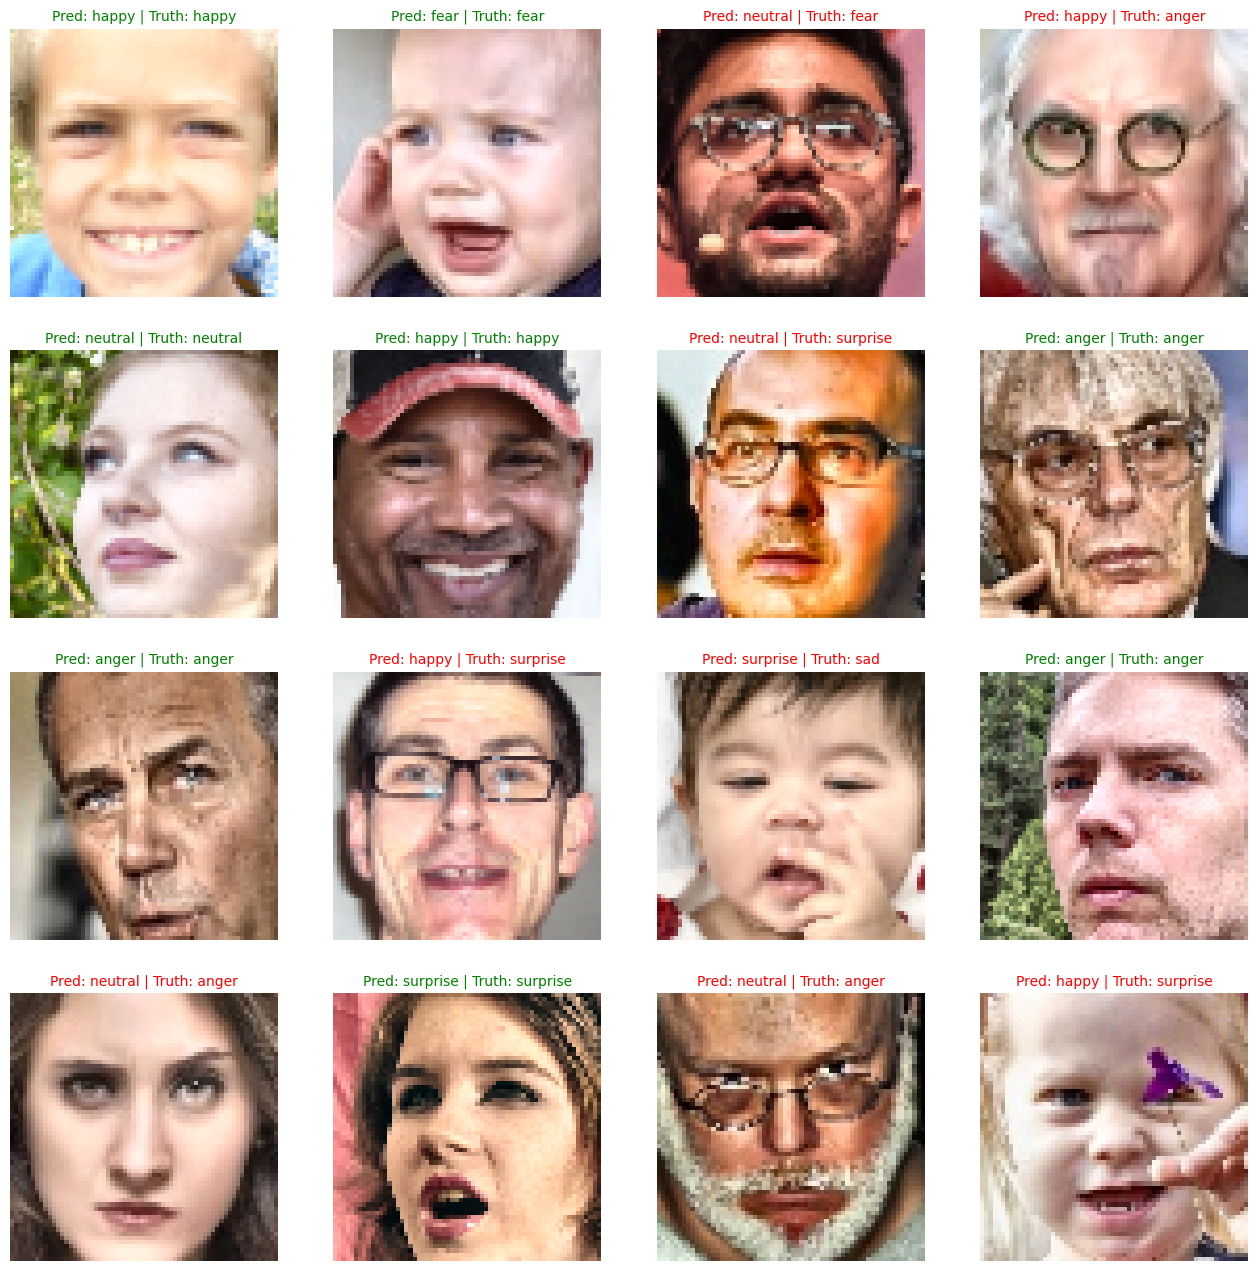

In [406]:
# Plot those images along with the predictions
import matplotlib.pyplot as plt
plt.figure(figsize=(16,16))
nrows, ncols = 4,4
unique_classes = lab
for i, sample in enumerate(test_samples):
  # Create subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.cpu())

  # Find the prediction
  pred_label =unique_classes[pred[i]]

  # Get the truth label
  truth_label = unique_classes[test_labels[i]]

  # Change the title for the plot
  title_text = f'Pred: {pred_label} | Truth: {truth_label}'

  '''Show red text title if the prediction is incorrect
    Show green text title of the prediction is correct'''

  if pred_label == truth_label:
    plt.title(title_text, fontsize=10, c='g')
  else:
    plt.title(title_text, fontsize=10, c='r')
  plt.axis(False)
plt.show()

## 10.2. Evaluation using confusion matrix

### 9.2.1. Import necessary libraries

In [407]:
# Installing and importing torchmetrics
!pip install torchmetrics
from torchmetrics import ConfusionMatrix
import mlxtend
mlxtend.__version__

'0.23.1'

## 10.2.2. Plot Confusion Matrix

In [408]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X in tqdm(X_test):
    X = X.to(device)
    # Forward pass
    y_logit = model((X.permute(2,0,1)).unsqueeze(0).to(torch.float32))
    # Turn prediction from logits and logits to prediction labels
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)

    # put predictions on cpu for plotting
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

  0%|          | 0/3226 [00:00<?, ?it/s]

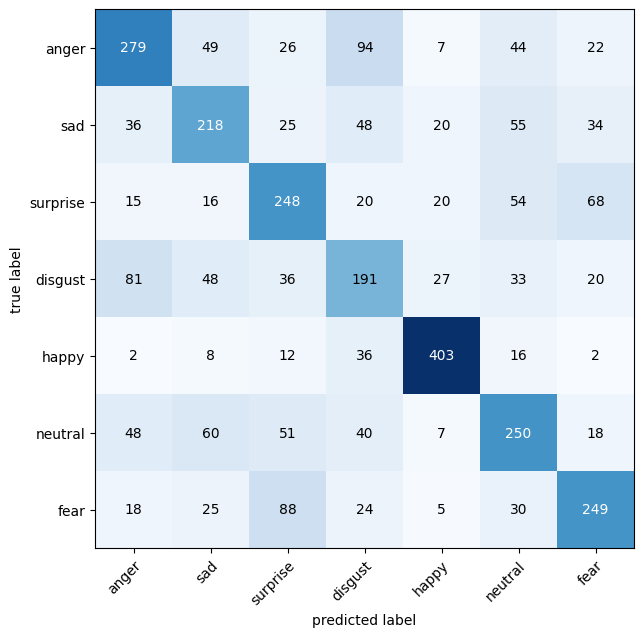

In [409]:
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion instance and compare pardictions to targets
confmat = ConfusionMatrix(task = 'multiclass',num_classes=len(set(valid_labels)))
confmat_tesnor=confmat(preds=y_pred_tensor,
                       target=torch.tensor(y_test))

# Plot our confusion matrix
fig, ax = plot_confusion_matrix(

    # matplotlib only works with numpy arrays and cnnot work with tensors
    conf_mat=confmat_tesnor.numpy(),
    class_names=list(set(valid_labels)),
    figsize=(10,7)
      )